In [114]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from keras.layers.normalization.layer_normalization import *
from keras.layers.normalization.batch_normalization import *
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [115]:
import csv
import pandas as pd

df = pd.read_json('bt_small.json')

df.to_csv('bt_small.txt', sep='\t', index=False)
print(df)

                                                                                                      en  \
26204521  Give me all the patients whose interval from the vaccination date to the onset date is 345.0.    
38205809                                                        List all the records using VAERS 2 form.   
8402306                             How many patients have Cytomegalovirus infection after vaccination?    
25104400                    Give me all the patients whose adverse event symptoms start from 06/01/2019.   
26204563  Give me all the patients whose interval from the vaccination date to the onset date is 200.0.    
...                                                                                                  ...   
12102600                                          Give me all the patients who is passed on 03/18/2020.    
25104143      Give me all the patients whose date of the onset of adverse event symptoms is 05/25/1998.    
3200876                     

In [116]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [117]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [118]:
data = read_text("bt_small.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)
deu_eng

array([['en', 'ja', 'ja_en'],
       ['Give me all the patients whose interval from the vaccination date to the onset date is 345.0. ',
        'ワクチン接種日から出発日までの間隔が345.0であるすべての患者を私に与えてください。',
        'Please give me all the patients with the interval from the vaccine date to the date of departure 345.0.'],
       [' List all the records using VAERS 2 form.',
        'すべてのレコードを VAERS 2 フォームを使用してリストします。',
        'List all records using the VAERS 2 form.'],
       [' How many patients have Cytomegalovirus infection after vaccination? ',
        'ワクチン接種後、どのくらいの患者がCytomegalovirus感染症を発症していますか?',
        'After vaccination, how many patients have Cytomegalovirus infection?'],
       [' Give me all the patients whose adverse event symptoms start from 06/01/2019.',
        'すべての患者に与え、その不適切な出来事の症状は2019年01月06日から始まります。',
        'To all patients, the symptoms of its inappropriate event begin on January 6, 2019.'],
       ['Give me all the patients whose interval from the vaccination date to the on

In [119]:
# convert text to lowercase
for i in range(1,len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,2] = deu_eng[i,2].lower()
    

C:\Users\WenlongZhang\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


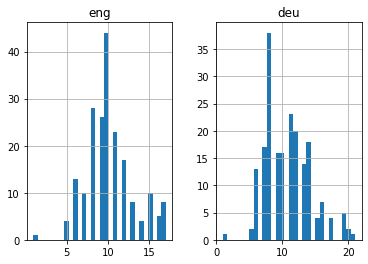

In [120]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,2]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

In [121]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    #tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [212]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 18
print('English Vocabulary Size: %d' % eng_vocab_size)
eng_tokenizer

English Vocabulary Size: 319


In [213]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 2])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 18
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 383


In [214]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [215]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [216]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 2])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 2])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [217]:
#keras.layers.normalization.BatchNormalization(epsilon=1e-6, weights=None) 

In [218]:
# build NMT model
 
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [219]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [220]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

C:\Users\WenlongZhang\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [221]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
print(trainY.shape)

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=500, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

(160, 18)
Epoch 1/500
1/1 [==============================] - ETA: 0s - loss: 5.7658
Epoch 1: val_loss improved from inf to 5.63131, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 19s 19s/step - loss: 5.7658 - val_loss: 5.6313
Epoch 2/500
1/1 [==============================] - ETA: 0s - loss: 5.6353
Epoch 2: val_loss improved from 5.63131 to 4.70496, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 5.6353 - val_loss: 4.7050
Epoch 3/500
1/1 [==============================] - ETA: 0s - loss: 4.9482
Epoch 3: val_loss did not improve from 4.70496
1/1 [==============================] - 2s 2s/step - loss: 4.9482 - val_loss: 5.6136
Epoch 4/500
1/1 [==============================] - ETA: 0s - loss: 5.6058
Epoch 4: val_loss improved from 4.70496 to 4.55737, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 5.6058 - val_loss: 4.5574
Epoch 5/500
1/1 [==============================] - ETA: 0s - loss: 4.5344
Epoch 5: val_loss improved from 4.55737 to 3.50019, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 4.5344 - val_loss: 3.5002
Epoch 6/500
1/1 [==============================] - ETA: 0s - loss: 3.6043
Epoch 6: val_loss did not improve from 3.50019
1/1 [==============================] - 2s 2s/step - loss: 3.6043 - val_loss: 3.5338
Epoch 7/500
1/1 [==============================] - ETA: 0s - loss: 3.5789
Epoch 7: val_loss improved from 3.50019 to 3.36899, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 3.5789 - val_loss: 3.3690
Epoch 8/500
1/1 [==============================] - ETA: 0s - loss: 3.4684
Epoch 8: val_loss improved from 3.36899 to 3.33057, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 14s 14s/step - loss: 3.4684 - val_loss: 3.3306
Epoch 9/500
1/1 [==============================] - ETA: 0s - loss: 3.3802
Epoch 9: val_loss improved from 3.33057 to 3.21457, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 3.3802 - val_loss: 3.2146
Epoch 10/500
1/1 [==============================] - ETA: 0s - loss: 3.2987
Epoch 10: val_loss did not improve from 3.21457
1/1 [==============================] - 2s 2s/step - loss: 3.2987 - val_loss: 3.4684
Epoch 11/500
1/1 [==============================] - ETA: 0s - loss: 3.5273
Epoch 11: val_loss did not improve from 3.21457
1/1 [==============================] - 2s 2s/step - loss: 3.5273 - val_loss: 3.3488
Epoch 12/500
1/1 [==============================] - ETA: 0s - loss: 3.4056
Epoch 12: val_loss did not improve from 3.21457
1/1 [==============================] - 2s 2s/step - loss: 3.4056 - val_loss: 3.2283
Epoch 13/500
1/1 [==============================] - ETA: 0s - loss: 3.2865
Epoch 13: val_loss improved from 3.21457 to 3.08673, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 3.2865 - val_loss: 3.0867
Epoch 14/500
1/1 [==============================] - ETA: 0s - loss: 3.1328
Epoch 14: val_loss improved from 3.08673 to 2.99255, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 3.1328 - val_loss: 2.9926
Epoch 15/500
1/1 [==============================] - ETA: 0s - loss: 3.0234
Epoch 15: val_loss improved from 2.99255 to 2.90001, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 3.0234 - val_loss: 2.9000
Epoch 16/500
1/1 [==============================] - ETA: 0s - loss: 2.9335
Epoch 16: val_loss did not improve from 2.90001
1/1 [==============================] - 2s 2s/step - loss: 2.9335 - val_loss: 3.9011
Epoch 17/500
1/1 [==============================] - ETA: 0s - loss: 3.9583
Epoch 17: val_loss did not improve from 2.90001
1/1 [==============================] - 2s 2s/step - loss: 3.9583 - val_loss: 3.2645
Epoch 18/500
1/1 [==============================] - ETA: 0s - loss: 3.2951
Epoch 18: val_loss did not improve from 2.90001
1/1 [==============================] - 2s 2s/step - loss: 3.2951 - val_loss: 3.1467
Epoch 19/500
1/1 [==============================] - ETA: 0s - loss: 3.1397
Epoch 19: val_loss did not improve from 2.90001
1/1 [==============================] - 2s 2s/step - loss: 3.1397 - val_loss: 3.0301
Epoch 20/500
1/1 [==============================] - ETA: 0s - loss: 3.0387
Epoch 20: v

INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 2.9454 - val_loss: 2.8856
Epoch 24/500
1/1 [==============================] - ETA: 0s - loss: 2.8791
Epoch 24: val_loss did not improve from 2.88562
1/1 [==============================] - 2s 2s/step - loss: 2.8791 - val_loss: 2.9815
Epoch 25/500
1/1 [==============================] - ETA: 0s - loss: 2.9386
Epoch 25: val_loss did not improve from 2.88562
1/1 [==============================] - 2s 2s/step - loss: 2.9386 - val_loss: 2.9975
Epoch 26/500
1/1 [==============================] - ETA: 0s - loss: 2.9783
Epoch 26: val_loss did not improve from 2.88562
1/1 [==============================] - 2s 2s/step - loss: 2.9783 - val_loss: 3.0040
Epoch 27/500
1/1 [==============================] - ETA: 0s - loss: 2.9592
Epoch 27: val_loss improved from 2.88562 to 2.78372, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 2.9592 - val_loss: 2.7837
Epoch 28/500
1/1 [==============================] - ETA: 0s - loss: 2.7331
Epoch 28: val_loss improved from 2.78372 to 2.72091, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 2.7331 - val_loss: 2.7209
Epoch 29/500
1/1 [==============================] - ETA: 0s - loss: 2.6616
Epoch 29: val_loss did not improve from 2.72091
1/1 [==============================] - 3s 3s/step - loss: 2.6616 - val_loss: 2.7860
Epoch 30/500
1/1 [==============================] - ETA: 0s - loss: 2.7414
Epoch 30: val_loss did not improve from 2.72091
1/1 [==============================] - 3s 3s/step - loss: 2.7414 - val_loss: 2.8277
Epoch 31/500
1/1 [==============================] - ETA: 0s - loss: 2.7393
Epoch 31: val_loss did not improve from 2.72091
1/1 [==============================] - 3s 3s/step - loss: 2.7393 - val_loss: 3.0728
Epoch 32/500
1/1 [==============================] - ETA: 0s - loss: 3.0485
Epoch 32: val_loss did not improve from 2.72091
1/1 [==============================] - 3s 3s/step - loss: 3.0485 - val_loss: 2.8597
Epoch 33/500
1/1 [==============================] - ETA: 0s - loss: 2.7270
Epoch 33: v

INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 14s 14s/step - loss: 2.7270 - val_loss: 2.6429
Epoch 34/500
1/1 [==============================] - ETA: 0s - loss: 2.5410
Epoch 34: val_loss improved from 2.64291 to 2.54224, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 2.5410 - val_loss: 2.5422
Epoch 35/500
1/1 [==============================] - ETA: 0s - loss: 2.4276
Epoch 35: val_loss did not improve from 2.54224
1/1 [==============================] - 3s 3s/step - loss: 2.4276 - val_loss: 2.5870
Epoch 36/500
1/1 [==============================] - ETA: 0s - loss: 2.4767
Epoch 36: val_loss did not improve from 2.54224
1/1 [==============================] - 2s 2s/step - loss: 2.4767 - val_loss: 2.9283
Epoch 37/500
1/1 [==============================] - ETA: 0s - loss: 2.7956
Epoch 37: val_loss did not improve from 2.54224
1/1 [==============================] - 2s 2s/step - loss: 2.7956 - val_loss: 3.1173
Epoch 38/500
1/1 [==============================] - ETA: 0s - loss: 3.0261
Epoch 38: val_loss did not improve from 2.54224
1/1 [==============================] - 2s 2s/step - loss: 3.0261 - val_loss: 2.8567
Epoch 39/500
1/1 [==============================] - ETA: 0s - loss: 2.7682
Epoch 39: v

INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 2.4637 - val_loss: 2.4930
Epoch 41/500
1/1 [==============================] - ETA: 0s - loss: 2.3426
Epoch 41: val_loss improved from 2.49304 to 2.46695, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 2.3426 - val_loss: 2.4670
Epoch 42/500
1/1 [==============================] - ETA: 0s - loss: 2.3283
Epoch 42: val_loss did not improve from 2.46695
1/1 [==============================] - 2s 2s/step - loss: 2.3283 - val_loss: 2.6027
Epoch 43/500
1/1 [==============================] - ETA: 0s - loss: 2.4106
Epoch 43: val_loss did not improve from 2.46695
1/1 [==============================] - 2s 2s/step - loss: 2.4106 - val_loss: 2.7639
Epoch 44/500
1/1 [==============================] - ETA: 0s - loss: 2.6521
Epoch 44: val_loss did not improve from 2.46695
1/1 [==============================] - 2s 2s/step - loss: 2.6521 - val_loss: 2.5776
Epoch 45/500
1/1 [==============================] - ETA: 0s - loss: 2.3466
Epoch 45: val_loss improved from 2.46695 to 2.44185, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 2.3466 - val_loss: 2.4419
Epoch 46/500
1/1 [==============================] - ETA: 0s - loss: 2.2483
Epoch 46: val_loss improved from 2.44185 to 2.39632, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 2.2483 - val_loss: 2.3963
Epoch 47/500
1/1 [==============================] - ETA: 0s - loss: 2.1777
Epoch 47: val_loss did not improve from 2.39632
1/1 [==============================] - 2s 2s/step - loss: 2.1777 - val_loss: 2.4252
Epoch 48/500
1/1 [==============================] - ETA: 0s - loss: 2.2241
Epoch 48: val_loss did not improve from 2.39632
1/1 [==============================] - 2s 2s/step - loss: 2.2241 - val_loss: 2.4490
Epoch 49/500
1/1 [==============================] - ETA: 0s - loss: 2.2046
Epoch 49: val_loss did not improve from 2.39632
1/1 [==============================] - 2s 2s/step - loss: 2.2046 - val_loss: 2.6244
Epoch 50/500
1/1 [==============================] - ETA: 0s - loss: 2.4574
Epoch 50: val_loss did not improve from 2.39632
1/1 [==============================] - 2s 2s/step - loss: 2.4574 - val_loss: 2.5456
Epoch 51/500
1/1 [==============================] - ETA: 0s - loss: 2.2595
Epoch 51: v

INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 2.3672 - val_loss: 2.3286
Epoch 53/500
1/1 [==============================] - ETA: 0s - loss: 2.0349
Epoch 53: val_loss improved from 2.32865 to 2.24419, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 2.0349 - val_loss: 2.2442
Epoch 54/500
1/1 [==============================] - ETA: 0s - loss: 1.9719
Epoch 54: val_loss did not improve from 2.24419
1/1 [==============================] - 2s 2s/step - loss: 1.9719 - val_loss: 2.2608
Epoch 55/500
1/1 [==============================] - ETA: 0s - loss: 1.9528
Epoch 55: val_loss did not improve from 2.24419
1/1 [==============================] - 2s 2s/step - loss: 1.9528 - val_loss: 2.3805
Epoch 56/500
1/1 [==============================] - ETA: 0s - loss: 2.1237
Epoch 56: val_loss did not improve from 2.24419
1/1 [==============================] - 2s 2s/step - loss: 2.1237 - val_loss: 2.5623
Epoch 57/500
1/1 [==============================] - ETA: 0s - loss: 2.1965
Epoch 57: val_loss did not improve from 2.24419
1/1 [==============================] - 2s 2s/step - loss: 2.1965 - val_loss: 2.5899
Epoch 58/500
1/1 [==============================] - ETA: 0s - loss: 2.3202
Epoch 58: v

INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 1.9202 - val_loss: 2.1930
Epoch 60/500
1/1 [==============================] - ETA: 0s - loss: 1.8559
Epoch 60: val_loss improved from 2.19299 to 2.18665, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 1.8559 - val_loss: 2.1867
Epoch 61/500
1/1 [==============================] - ETA: 0s - loss: 1.8542
Epoch 61: val_loss did not improve from 2.18665
1/1 [==============================] - 3s 3s/step - loss: 1.8542 - val_loss: 2.1882
Epoch 62/500
1/1 [==============================] - ETA: 0s - loss: 1.9386
Epoch 62: val_loss improved from 2.18665 to 2.10780, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 14s 14s/step - loss: 1.9386 - val_loss: 2.1078
Epoch 63/500
1/1 [==============================] - ETA: 0s - loss: 1.7878
Epoch 63: val_loss improved from 2.10780 to 2.05090, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 1.7878 - val_loss: 2.0509
Epoch 64/500
1/1 [==============================] - ETA: 0s - loss: 1.7413
Epoch 64: val_loss did not improve from 2.05090
1/1 [==============================] - 3s 3s/step - loss: 1.7413 - val_loss: 2.2118
Epoch 65/500
1/1 [==============================] - ETA: 0s - loss: 1.8820
Epoch 65: val_loss did not improve from 2.05090
1/1 [==============================] - 3s 3s/step - loss: 1.8820 - val_loss: 2.8850
Epoch 66/500
1/1 [==============================] - ETA: 0s - loss: 2.5148
Epoch 66: val_loss did not improve from 2.05090
1/1 [==============================] - 3s 3s/step - loss: 2.5148 - val_loss: 2.8656
Epoch 67/500
1/1 [==============================] - ETA: 0s - loss: 2.4993
Epoch 67: val_loss did not improve from 2.05090
1/1 [==============================] - 3s 3s/step - loss: 2.4993 - val_loss: 2.2044
Epoch 68/500
1/1 [==============================] - ETA: 0s - loss: 2.0701
Epoch 68: v

INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 1.6968 - val_loss: 2.0361
Epoch 71/500
1/1 [==============================] - ETA: 0s - loss: 1.6473
Epoch 71: val_loss did not improve from 2.03613
1/1 [==============================] - 3s 3s/step - loss: 1.6473 - val_loss: 2.0387
Epoch 72/500
1/1 [==============================] - ETA: 0s - loss: 1.6240
Epoch 72: val_loss did not improve from 2.03613
1/1 [==============================] - 2s 2s/step - loss: 1.6240 - val_loss: 2.0545
Epoch 73/500
1/1 [==============================] - ETA: 0s - loss: 1.6620
Epoch 73: val_loss did not improve from 2.03613
1/1 [==============================] - 2s 2s/step - loss: 1.6620 - val_loss: 2.1299
Epoch 74/500
1/1 [==============================] - ETA: 0s - loss: 1.7070
Epoch 74: val_loss did not improve from 2.03613
1/1 [==============================] - 2s 2s/step - loss: 1.7070 - val_loss: 2.1709
Epoch 75/500
1/1 [==============================] - ETA: 0s - loss: 1.8012
Epoch 75: v

INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 1.6901 - val_loss: 2.0278
Epoch 78/500
1/1 [==============================] - ETA: 0s - loss: 1.5074
Epoch 78: val_loss improved from 2.02776 to 1.94674, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 1.5074 - val_loss: 1.9467
Epoch 79/500
1/1 [==============================] - ETA: 0s - loss: 1.4804
Epoch 79: val_loss did not improve from 1.94674
1/1 [==============================] - 2s 2s/step - loss: 1.4804 - val_loss: 1.9664
Epoch 80/500
1/1 [==============================] - ETA: 0s - loss: 1.4681
Epoch 80: val_loss did not improve from 1.94674
1/1 [==============================] - 2s 2s/step - loss: 1.4681 - val_loss: 2.1459
Epoch 81/500
1/1 [==============================] - ETA: 0s - loss: 1.5677
Epoch 81: val_loss did not improve from 1.94674
1/1 [==============================] - 2s 2s/step - loss: 1.5677 - val_loss: 2.1170
Epoch 82/500
1/1 [==============================] - ETA: 0s - loss: 1.6653
Epoch 82: val_loss did not improve from 1.94674
1/1 [==============================] - 2s 2s/step - loss: 1.6653 - val_loss: 2.3092
Epoch 83/500
1/1 [==============================] - ETA: 0s - loss: 1.9481
Epoch 83: v

INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 1.4276 - val_loss: 1.9330
Epoch 87/500
1/1 [==============================] - ETA: 0s - loss: 1.4242
Epoch 87: val_loss improved from 1.93305 to 1.86712, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 1.4242 - val_loss: 1.8671
Epoch 88/500
1/1 [==============================] - ETA: 0s - loss: 1.3362
Epoch 88: val_loss did not improve from 1.86712
1/1 [==============================] - 3s 3s/step - loss: 1.3362 - val_loss: 1.9176
Epoch 89/500
1/1 [==============================] - ETA: 0s - loss: 1.3412
Epoch 89: val_loss did not improve from 1.86712
1/1 [==============================] - 2s 2s/step - loss: 1.3412 - val_loss: 1.9478
Epoch 90/500
1/1 [==============================] - ETA: 0s - loss: 1.4081
Epoch 90: val_loss did not improve from 1.86712
1/1 [==============================] - 2s 2s/step - loss: 1.4081 - val_loss: 2.1025
Epoch 91/500
1/1 [==============================] - ETA: 0s - loss: 1.5448
Epoch 91: val_loss did not improve from 1.86712
1/1 [==============================] - 2s 2s/step - loss: 1.5448 - val_loss: 2.0246
Epoch 92/500
1/1 [==============================] - ETA: 0s - loss: 1.4459
Epoch 92: v

INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 1.3224 - val_loss: 1.8644
Epoch 96/500
1/1 [==============================] - ETA: 0s - loss: 1.2270
Epoch 96: val_loss did not improve from 1.86436
1/1 [==============================] - 3s 3s/step - loss: 1.2270 - val_loss: 1.9513
Epoch 97/500
1/1 [==============================] - ETA: 0s - loss: 1.2441
Epoch 97: val_loss improved from 1.86436 to 1.83025, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 14s 14s/step - loss: 1.2441 - val_loss: 1.8303
Epoch 98/500
1/1 [==============================] - ETA: 0s - loss: 1.2150
Epoch 98: val_loss did not improve from 1.83025
1/1 [==============================] - 3s 3s/step - loss: 1.2150 - val_loss: 1.9235
Epoch 99/500
1/1 [==============================] - ETA: 0s - loss: 1.2096
Epoch 99: val_loss did not improve from 1.83025
1/1 [==============================] - 3s 3s/step - loss: 1.2096 - val_loss: 1.9913
Epoch 100/500
1/1 [==============================] - ETA: 0s - loss: 1.3761
Epoch 100: val_loss did not improve from 1.83025
1/1 [==============================] - 3s 3s/step - loss: 1.3761 - val_loss: 2.2067
Epoch 101/500
1/1 [==============================] - ETA: 0s - loss: 1.5761
Epoch 101: val_loss did not improve from 1.83025
1/1 [==============================] - 3s 3s/step - loss: 1.5761 - val_loss: 2.2430
Epoch 102/500
1/1 [==============================] - ETA: 0s - loss: 1.6695
Epoch 

INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 1.2503 - val_loss: 1.8300
Epoch 104/500
1/1 [==============================] - ETA: 0s - loss: 1.1564
Epoch 104: val_loss improved from 1.82998 to 1.77207, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 1.1564 - val_loss: 1.7721
Epoch 105/500
1/1 [==============================] - ETA: 0s - loss: 1.0798
Epoch 105: val_loss improved from 1.77207 to 1.75842, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 12s 12s/step - loss: 1.0798 - val_loss: 1.7584
Epoch 106/500
1/1 [==============================] - ETA: 0s - loss: 1.0542
Epoch 106: val_loss did not improve from 1.75842
1/1 [==============================] - 3s 3s/step - loss: 1.0542 - val_loss: 1.7756
Epoch 107/500
1/1 [==============================] - ETA: 0s - loss: 1.0224
Epoch 107: val_loss improved from 1.75842 to 1.73269, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 1.0224 - val_loss: 1.7327
Epoch 108/500
1/1 [==============================] - ETA: 0s - loss: 1.0209
Epoch 108: val_loss did not improve from 1.73269
1/1 [==============================] - 3s 3s/step - loss: 1.0209 - val_loss: 1.8334
Epoch 109/500
1/1 [==============================] - ETA: 0s - loss: 1.0280
Epoch 109: val_loss did not improve from 1.73269
1/1 [==============================] - 3s 3s/step - loss: 1.0280 - val_loss: 1.7419
Epoch 110/500
1/1 [==============================] - ETA: 0s - loss: 1.0351
Epoch 110: val_loss did not improve from 1.73269
1/1 [==============================] - 3s 3s/step - loss: 1.0351 - val_loss: 1.8449
Epoch 111/500
1/1 [==============================] - ETA: 0s - loss: 1.0292
Epoch 111: val_loss did not improve from 1.73269
1/1 [==============================] - 3s 3s/step - loss: 1.0292 - val_loss: 1.8179
Epoch 112/500
1/1 [==============================] - ETA: 0s - loss: 1.0684
Ep

INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 0.9215 - val_loss: 1.7292
Epoch 132/500
1/1 [==============================] - ETA: 0s - loss: 0.8373
Epoch 132: val_loss did not improve from 1.72923
1/1 [==============================] - 3s 3s/step - loss: 0.8373 - val_loss: 1.7853
Epoch 133/500
1/1 [==============================] - ETA: 0s - loss: 0.8286
Epoch 133: val_loss did not improve from 1.72923
1/1 [==============================] - 3s 3s/step - loss: 0.8286 - val_loss: 1.8037
Epoch 134/500
1/1 [==============================] - ETA: 0s - loss: 0.8792
Epoch 134: val_loss did not improve from 1.72923
1/1 [==============================] - 3s 3s/step - loss: 0.8792 - val_loss: 1.9559
Epoch 135/500
1/1 [==============================] - ETA: 0s - loss: 1.0825
Epoch 135: val_loss did not improve from 1.72923
1/1 [==============================] - 2s 2s/step - loss: 1.0825 - val_loss: 1.9565
Epoch 136/500
1/1 [==============================] - ETA: 0s - loss: 0.9727
Ep

INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 0.7623 - val_loss: 1.7018
Epoch 142/500
1/1 [==============================] - ETA: 0s - loss: 0.7132
Epoch 142: val_loss did not improve from 1.70181
1/1 [==============================] - 2s 2s/step - loss: 0.7132 - val_loss: 1.8048
Epoch 143/500
1/1 [==============================] - ETA: 0s - loss: 0.7458
Epoch 143: val_loss did not improve from 1.70181
1/1 [==============================] - 2s 2s/step - loss: 0.7458 - val_loss: 1.7814
Epoch 144/500
1/1 [==============================] - ETA: 0s - loss: 0.8100
Epoch 144: val_loss did not improve from 1.70181
1/1 [==============================] - 2s 2s/step - loss: 0.8100 - val_loss: 1.9551
Epoch 145/500
1/1 [==============================] - ETA: 0s - loss: 0.9159
Epoch 145: val_loss did not improve from 1.70181
1/1 [==============================] - 2s 2s/step - loss: 0.9159 - val_loss: 1.9058
Epoch 146/500
1/1 [==============================] - ETA: 0s - loss: 0.8992
Ep

INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


1/1 [==============================] - 13s 13s/step - loss: 0.6179 - val_loss: 1.6951
Epoch 164/500
1/1 [==============================] - ETA: 0s - loss: 0.5818
Epoch 164: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.5818 - val_loss: 1.7439
Epoch 165/500
1/1 [==============================] - ETA: 0s - loss: 0.5801
Epoch 165: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.5801 - val_loss: 1.7363
Epoch 166/500
1/1 [==============================] - ETA: 0s - loss: 0.5809
Epoch 166: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.5809 - val_loss: 1.7787
Epoch 167/500
1/1 [==============================] - ETA: 0s - loss: 0.6312
Epoch 167: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.6312 - val_loss: 1.8554
Epoch 168/500
1/1 [==============================] - ETA: 0s - loss: 0.6757
Ep

Epoch 203/500
1/1 [==============================] - ETA: 0s - loss: 0.4587
Epoch 203: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.4587 - val_loss: 1.9423
Epoch 204/500
1/1 [==============================] - ETA: 0s - loss: 0.4782
Epoch 204: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.4782 - val_loss: 1.9433
Epoch 205/500
1/1 [==============================] - ETA: 0s - loss: 0.5134
Epoch 205: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.5134 - val_loss: 2.0329
Epoch 206/500
1/1 [==============================] - ETA: 0s - loss: 0.4788
Epoch 206: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.4788 - val_loss: 1.8517
Epoch 207/500
1/1 [==============================] - ETA: 0s - loss: 0.5199
Epoch 207: val_loss did not improve from 1.69512
1/1 [==============================] - 

1/1 [==============================] - ETA: 0s - loss: 0.3245
Epoch 242: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.3245 - val_loss: 1.9917
Epoch 243/500
1/1 [==============================] - ETA: 0s - loss: 0.3895
Epoch 243: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.3895 - val_loss: 1.9820
Epoch 244/500
1/1 [==============================] - ETA: 0s - loss: 0.3951
Epoch 244: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.3951 - val_loss: 2.1951
Epoch 245/500
1/1 [==============================] - ETA: 0s - loss: 0.4235
Epoch 245: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.4235 - val_loss: 2.1575
Epoch 246/500
1/1 [==============================] - ETA: 0s - loss: 0.3912
Epoch 246: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - l

1/1 [==============================] - ETA: 0s - loss: 0.1909
Epoch 281: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.1909 - val_loss: 1.8915
Epoch 282/500
1/1 [==============================] - ETA: 0s - loss: 0.1787
Epoch 282: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.1787 - val_loss: 1.9020
Epoch 283/500
1/1 [==============================] - ETA: 0s - loss: 0.1717
Epoch 283: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.1717 - val_loss: 1.9074
Epoch 284/500
1/1 [==============================] - ETA: 0s - loss: 0.1663
Epoch 284: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.1663 - val_loss: 1.9142
Epoch 285/500
1/1 [==============================] - ETA: 0s - loss: 0.1618
Epoch 285: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - l

1/1 [==============================] - ETA: 0s - loss: 0.1614
Epoch 320: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.1614 - val_loss: 2.3093
Epoch 321/500
1/1 [==============================] - ETA: 0s - loss: 0.1936
Epoch 321: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.1936 - val_loss: 2.2413
Epoch 322/500
1/1 [==============================] - ETA: 0s - loss: 0.2060
Epoch 322: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.2060 - val_loss: 2.3072
Epoch 323/500
1/1 [==============================] - ETA: 0s - loss: 0.2113
Epoch 323: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.2113 - val_loss: 2.2826
Epoch 324/500
1/1 [==============================] - ETA: 0s - loss: 0.1923
Epoch 324: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - l

1/1 [==============================] - ETA: 0s - loss: 0.1384
Epoch 359: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.1384 - val_loss: 2.3953
Epoch 360/500
1/1 [==============================] - ETA: 0s - loss: 0.1797
Epoch 360: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.1797 - val_loss: 2.6489
Epoch 361/500
1/1 [==============================] - ETA: 0s - loss: 0.2576
Epoch 361: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.2576 - val_loss: 2.5450
Epoch 362/500
1/1 [==============================] - ETA: 0s - loss: 0.2292
Epoch 362: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.2292 - val_loss: 2.4707
Epoch 363/500
1/1 [==============================] - ETA: 0s - loss: 0.2295
Epoch 363: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - l

1/1 [==============================] - ETA: 0s - loss: 0.1015
Epoch 398: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.1015 - val_loss: 2.6957
Epoch 399/500
1/1 [==============================] - ETA: 0s - loss: 0.1382
Epoch 399: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.1382 - val_loss: 2.7213
Epoch 400/500
1/1 [==============================] - ETA: 0s - loss: 0.1295
Epoch 400: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.1295 - val_loss: 2.7880
Epoch 401/500
1/1 [==============================] - ETA: 0s - loss: 0.1741
Epoch 401: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.1741 - val_loss: 2.6348
Epoch 402/500
1/1 [==============================] - ETA: 0s - loss: 0.1816
Epoch 402: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - l

1/1 [==============================] - ETA: 0s - loss: 0.0434
Epoch 437: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.0434 - val_loss: 2.6495
Epoch 438/500
1/1 [==============================] - ETA: 0s - loss: 0.0437
Epoch 438: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.0437 - val_loss: 2.6349
Epoch 439/500
1/1 [==============================] - ETA: 0s - loss: 0.0452
Epoch 439: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.0452 - val_loss: 2.6546
Epoch 440/500
1/1 [==============================] - ETA: 0s - loss: 0.0467
Epoch 440: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.0467 - val_loss: 2.6430
Epoch 441/500
1/1 [==============================] - ETA: 0s - loss: 0.0454
Epoch 441: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - l

1/1 [==============================] - ETA: 0s - loss: 0.0709
Epoch 476: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.0709 - val_loss: 2.7996
Epoch 477/500
1/1 [==============================] - ETA: 0s - loss: 0.1105
Epoch 477: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.1105 - val_loss: 2.8828
Epoch 478/500
1/1 [==============================] - ETA: 0s - loss: 0.2759
Epoch 478: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.2759 - val_loss: 3.3056
Epoch 479/500
1/1 [==============================] - ETA: 0s - loss: 0.4654
Epoch 479: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - loss: 0.4654 - val_loss: 2.9833
Epoch 480/500
1/1 [==============================] - ETA: 0s - loss: 0.4964
Epoch 480: val_loss did not improve from 1.69512
1/1 [==============================] - 2s 2s/step - l

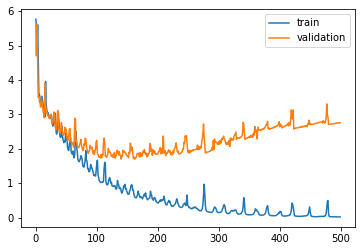

In [222]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [223]:
import numpy as np
model = load_model('model.h1.24_jan_19')
preds = np.argmax(model.predict(testX.reshape((testX.shape[0],testX.shape[1]))),axis = -1)
preds[0]

2/2 [==============================] - 2s 115ms/step


array([ 5,  4,  3,  1,  2,  6, 12, 12, 46, 47, 47,  0,  0,  0,  0,  0,  0,
        0], dtype=int64)

In [224]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [225]:
# convert predictions into text (English)
preds_text = []
for i in preds:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], eng_tokenizer)
    if j>0:
      if(t == get_word(i[j-1], eng_tokenizer)) or (t == None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if(t == None):
        temp.append('')
      else:
        temp.append(t)

  preds_text.append(' '.join(temp))

In [226]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
# print 15 rows randomly
pred_df.head(15)

,actual,predicted
0,give me all the patients who got influenza (seasonal) (fluad) and influenza (seasonal) (fluad).,give me all the patients who got manufactured by
1,give me all the patients who got dtphep.,give me all the patients who 2 for 0
2,list all the recipients who took typhoid vi polysaccharide and typhoid vi polysaccharide before.,give me the who hospitalized and before
3,give me all the patients whose interval from the vaccination date to the onset date is 776.0.,give me all the patients whose interval from the date is 0
4,how many patients is passed on 05/03/2021.,how many patients' information are received on 04 2021
5,give me all the patients who got uspfizer inc202100952508 vaccine.,give me all the patients who got vaccine by
6,how many patients' information are received on 07/14/2021,how many patients' information are on 04 2021
7,how many patients complete their reports on 04/05/2021.,how many patients' information are received on 2021
8,give me all the patients whose date of the onset of adverse event symptoms is 06/04/2021.,give me all the patients whose date of adverse symptoms is 2021
9,"give me all the patients who got influenza (seasonal) (fluenz) and polio virus, oral (no brand name).",give me all the patients who got yellow and


In [227]:
pred_df.to_excel("NL2TE covert results.xlsx")


In [158]:
data = read_text("logic form1.txt")
eng[10][0].split(" ")




['Queryfield',
 '{',
 'condition',
 '=',
 '',
 '=',
 'LAB_DATA#value',
 '=',
 '',
 '=',
 'muscle',
 'creatine',
 '}',
 '']

In [159]:

str1=''.join(preds_text[1])
str2=str1.split(" ")

str2


['=',
 '',
 'vax_name#value',
 '=',
 '',
 'covid-19',
 '}',
 ';',
 '{',
 'condition',
 '=',
 '',
 'prior_vax#value',
 '=',
 '',
 'varcel',
 '}',
 '']

In [173]:
a=[]
for i in range(len(eng)): 
    tokens=''.join(eng[i][0]).split(" ")
    if tokens!=' ':  
        if tokens!='':
            a.append(tokens)
b=[]
for i in range(len(preds_text)): 
    tokens=''.join(preds_text[i]).split(" ")
    if tokens!=' ':  
        if tokens!='':
            b.append(tokens)

print(a)

[['Queryfield', '{', 'condition', '=', '', '=', 'STATE#value', '=', '', '=', 'CA', '}', ''], ['Queryfield', '{', 'condition', '=', '', '=', 'AGE_YRS#value', '=', '', '=', '10', '}', ''], ['Queryfield', '{', 'condition', '=', '', '=', 'AGE_YRS#value', '=', '', '=', '10', '}', ''], ['Queryfield', '{', 'condition', '=', '', '=', 'AGE_YRS#value', '=', '', '=', '10', '}', ''], ['Queryfield', '{', 'condition', '=', '', '=', 'PRIOR_VAX_DATE#value', '=', '', '=', '12/15/2020', '}', ''], ['Queryfield', '{', 'condition', '=', '', '=', 'VAX_NAME#value', '=', '', '=', 'INFLUENZA', '}', ''], ['Queryfield', '{', 'condition', '=', '', '=', 'VAX_NAME#value', '=', '', '=', '', 'LA||RA', '}', ''], ['Queryfield', '{', 'condition', '=', '', '=', 'AGE_YRS#value', '=', '', '=', '', '[', '10', ',', '20', ']', '', '}', ''], ['Queryfield', '{', '', '{', 'condition', '=', '', '=', 'SYMPTOM_TEXT#value', '=', '', '=', 'chills', '}', '', ';', '', '{', 'condition', '=', '', '=', 'OFC_VISIT#value', '=', '', '=', 'Y'

In [172]:
from nltk.translate.bleu_score import sentence_bleu
references = a
candidates = b
for candidate in candidates:
    print(sentence_bleu(references, candidate))

0.3436305934265449
0.34823528327578535
0.21468316165048362
0.21468316165048362
0.22729027327004608
0.34823528327578535
0.21468316165048362
0.21468316165048362
0.573057404379869
0.22729027327004608
0.22250253290431038
0.6012909138105229
0.2600768235722905
0.5081327481546147
0.5081327481546147
0.22250253290431038
0.5623413251903491
0.2600768235722905
0.22250253290431038
0.36821398145189993
0.2600768235722905
0.34823528327578535
0.22250253290431038
0.5623413251903491
0.22729027327004608
0.22729027327004608
0.6012909138105229
0.22250253290431038
0.34823528327578535
0.34823528327578535


In [ ]:
rouge_1 = keras_nlp.metrics.RougeN(order=1)
rouge_2 = keras_nlp.metrics.RougeN(order=2)

for test_pair in test_pairs[:30]:
    input_sentence = test_pair[0]
    reference_sentence = test_pair[1]

    translated_sentence = decode_sequences(tf.constant([input_sentence]))
    translated_sentence = translated_sentence.numpy()[0].decode("utf-8")
    translated_sentence = (
        translated_sentence.replace("[PAD]", "")
        .replace("[START]", "")
        .replace("[END]", "")
        .strip()
    )

    rouge_1(reference_sentence, translated_sentence)
    rouge_2(reference_sentence, translated_sentence)

print("ROUGE-1 Score: ", rouge_1.result())
print("ROUGE-2 Score: ", rouge_2.result())